# COMP9444 Project
## Group - 'To Be Decided'
## Spoken Language Identification

Joel Bryla (z5361331), Andrea Dobles (z5394074), Mikkel Endresen (z5304263), Gajendra Jayasekera (z5260252), Gayathrie Vijayalingam (z5193713)

## Introduction

Automatic language identification (LID) is a challenging problem in speech signalling processing. The task is to identify the language of a given audio clip. Unlike parsing through written text, algorithms need to take in audio samples, which can vary widely in quality and length, with variations as well in speakers’ genders, age, accents, and dialects.

LID is an important first step in many applications that use Automatic Speech Recognition (ASR) systems, such as multilingual voice assistants, transcription and translation services, and content filtering on social media; but may also serve an important purpose on its own, such as in emergency services, where transferring the call to an operator who can speak the caller’s first language may save lives.

The current state-of-the-art approaches to spoken language identification use deep learning. There are two main systems — end-to-end systems where feature extraction and classification are done with a single system, and hybrid neural network systems that use more resources but are more accurate. This tradeoff is important to take into consideration for real-time applications, where we may favour speed over accuracy.

In this project, we aim to improve upon existing deep learning models and combine features of these models to create a model that is both fast and accurate.

## Data
The following code blocks load the dataset, as well as the saved models.

Add folder to your drive [link](https://drive.google.com/drive/folders/1ln4Zubufw3sFldJVr6ITQJ6Au-QaMzsC?usp=drive_link), then for folder add shortcut to drive and put in `My Drive` folder.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import IPython
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sklearn.metrics as metrics
import torchaudio
import random
import torchaudio.transforms as T
import inspect

In [31]:
try:
  from google.colab import drive, data_table
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  data_table.enable_dataframe_formatter()
  drive.mount('/content/drive')
  %cd '/content/drive/MyDrive/COMP9444'

dataset_PATH = "data"
model_PATH = "models"
rand_generator = torch.Generator().manual_seed(7)
random.seed(7)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pd.options.display.float_format = '{:.3f}'.format

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1ln4Zubufw3sFldJVr6ITQJ6Au-QaMzsC/COMP9444


In [32]:
RESULTS = torch.load("results.pt", map_location=DEVICE).round(3)

show_cols = ["Model","Learning Rate","Weight Decay","Optimizer","LR_Scheduler","Dropout","Batch Size","Training Epochs","Train Loss","Validation Loss","Test Loss","Validation Accuracy","Test Accuracy"]

def fix_fig(fig):
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)
    return fig

def show_model(models, train=True, conf_valid=True, conf_test=True):
    for _, model in models.iterrows():
        print(model[show_cols].to_markdown())
        if train:
            plt.figure(fix_fig(model["training_plot"]))
            plt.show()
        if conf_valid:
            plt.figure(fix_fig(model["Validation Confusion Matrix"]))
            plt.show()
        if conf_test:
            plt.figure(fix_fig(model["Test Confusion Matrix"]))
            plt.show()

### Voxlingua107 Dataset

Our chosen dataset Voxlingua107 is specifically designed for spoken language identification problems containing over 6000 hours of audio between 107 languages with the data being collected and labelled automatically.

The process in which the sample are generated is:
1. Language specific wikipedia page dumps are analysed to find the most "important" words for the language
2. Youtube.com is then queried for videos containing these words
3. The resulting clips are then run through a speech activity detection system to only extract segments containing speech
4. Then a  language embeddings classifier trained on the clips is used to filter outliers

The authors claim this automated method has 98% accuracy of correctly labelled samples based on a crowdsourced validation. But there is also a significantly smaller development set provided with the dataset which contain samples which have been manually validated to be of that language by 2 humans.

The benefit of the dataset being sourced from youtube is the variety of speech available as input as both scripted high quality spoken speech and real conversational spontaneous speech will both be found. Though being completely sourced from youtube is likely not to be representative of most real populations due to the over-representation of certain genders, ages and countries/ accents on the website.

The paper outlining the dataset is [Jörgen Valk, Tanel Alumäe. VoxLingua107: a Dataset for Spoken Language Recognition. Proc. SLT 2021.](https://arxiv.org/abs/2011.12998)

All data was downloaded from the dataset's site: https://bark.phon.ioc.ee/voxlingua107/

#### Chosen Languages
For our purposes the aim was to evaluate the flexibility of our models by having accurate classification of both languages with very little similarity and languages which share many features.

The three initial languages chosen were **English**, **Arabic** and **Mandarin Chinese** due to being vastly different and an easy task for humans to distinguish. Each comes from a distinctly different language family Indo-European, Semitic and Sino-Tibetan respectively.

**Danish** and **Swedish** were then picked as similar languages (both North Germanic) as even many humans will have difficulty differentiating. Both also sharing similarities with English a West Germanic languages (all three being Indo-European).

In [33]:
# [arabic, danish, english, swedish, mandarin]
LANGUAGES = ["ar", "da", "en", "sv", "zh"]
N_LANGUAGES = len(LANGUAGES)  # 5

For each language taking the respective data from the Voxlingua107 dataset, 5 second clips were extracted from each file. e.g. 6 second clip returns 1 clip and a 11 second clip can return 2 clips. These clips at a sample rate of 16000Hz contain 80,0000 data points.

As an example taking a sample:

In [34]:
DURATION = 5  # seconds
sample_rate = 16000  # hertz

file_path = os.path.join("dev", "en", os.listdir(os.path.join("dev", "en"))[33])
waveform, sample_rate = torchaudio.load(file_path)
# take the first channel of audio and first 5 seconds
waveform = waveform[0][: sample_rate * DURATION]
IPython.display.Audio(waveform, rate=sample_rate)

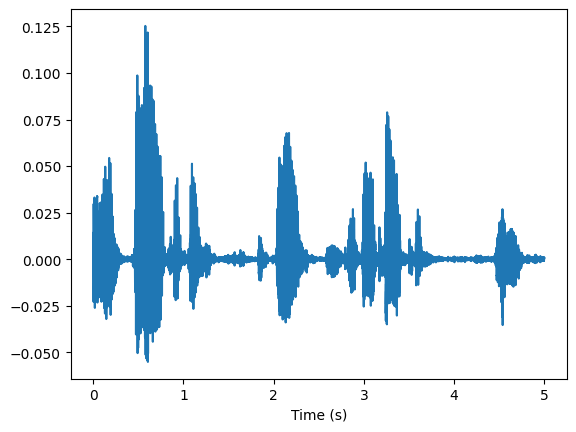

In [35]:
plt.plot(np.arange(DURATION, step=1 / sample_rate), waveform)
plt.xlabel("Time (s)")
plt.show()

Data in this form is long and unmanageable for a neural network to find features to make the data usable the problem is converted to a image feature detection problem by converting the waveform to a spectrogram. This is currently a common method in the spoken language recognition field.

A spectrogram is 2d, visual data representation of an audio signal, created by a series of short time Fourier transforms (STFT) run on the input waveform and patched together. The x axis is time and y axis is frequency. With each point being the intensity of that frequency at a that point in time.

For our above 5 second audio sample the resulting spectrogram with a width of 602 frames is:

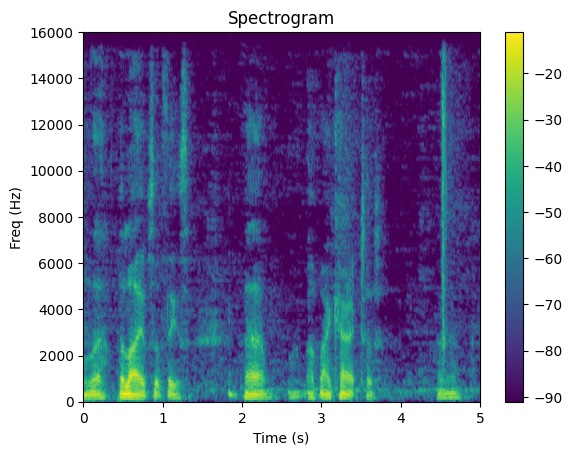

In [36]:
# function to plot with logarithmic decibel scale
def plot_spectrogram(specgram, y_max, title, ylabel=""):
    fig, axs = plt.subplots()
    axs.set_title(title)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("Time (s)")
    im = axs.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        extent=(0, DURATION, 0, y_max),
    )
    fig.colorbar(im, ax=axs)
    plt.show()


Spectrogram = torchaudio.transforms.Spectrogram(
    normalized=True, hop_length=DURATION * sample_rate // 600
)

output_spectrogram = Spectrogram(waveform)
plot_spectrogram(output_spectrogram, sample_rate, "Spectrogram", "Freq (Hz)")

This spectrogram is effective at representing the reality of the waveform but spoken language recognition is task centred in human perception and as humans appear to best at this task (so far) it makes sense to transform the input towards the human perception. A common way of addressing the problem is by using the Mel Scale.

It has be shown that humans perceive changes in pitch logarithmically and by transforming from a linear scale of pitch (Hertz) to a perceptual scale of pitches such as the Mel Scale the spectrogram can be adapted to fit closer to the human perception of pitch.

The transformation from Hertz to Mels is given by $m = 2595 \log_{10}(1 + \frac{f}{700})$.
In practice the transformation is applied with a number of filters which map from a input frequency to an output mel frequency, for our project 39 of these filters were used meaning our resulting input spectrogram was a $(39\times 602)$ tensor.

Below shows these equally spaced in mel space filter banks, clearly illustrating the logarithmic scale as pitch increases:

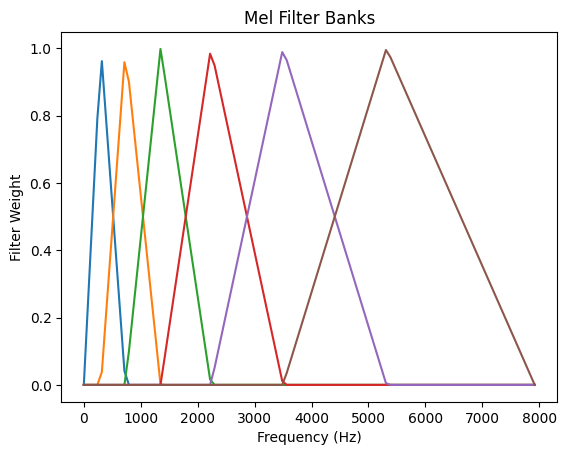

In [37]:
filters = torchaudio.functional.melscale_fbanks(
    n_freqs=101, f_min=0, f_max=sample_rate // 2, n_mels=6, sample_rate=sample_rate
)
plt.plot(
    np.arange(sample_rate // 2, step=sample_rate // 2 / 101), filters
)
plt.title("Mel Filter Banks")
plt.ylabel("Filter Weight")
plt.xlabel("Frequency (Hz)")
plt.show()

Using the above example spectrogram the resulting scaled Mel-spectrogram is:

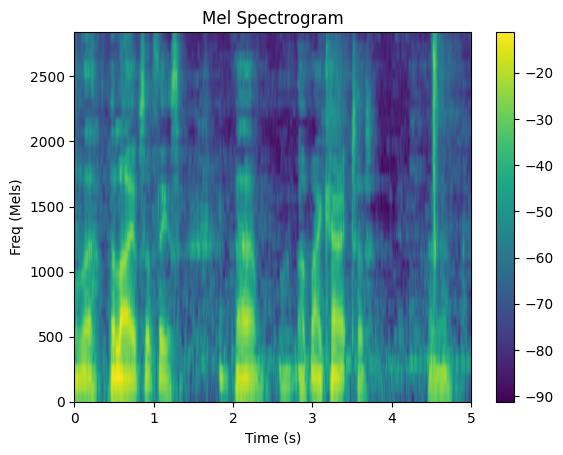

In [38]:
mel_spec = torchaudio.transforms.MelSpectrogram(
    n_mels=39, hop_length=DURATION * 16000 // 600, normalized=True
)

m_max = torchaudio.functional.functional._hz_to_mel(sample_rate // 2)

output_mel_spectrogram = mel_spec(waveform)
plot_spectrogram(mel_spec(waveform), m_max, "Mel Spectrogram", "Freq (Mels)")

Creating and partitioning our dataset once applying the spectrograms to all the 5 second clips for the 5 languages, a random sample of each class is taken such that the total number of samples for each class is equal.

This resulted in `71,365` total clips at ~100 hours, which was then split 80:20 between the training set and validation set, 57092 to 14273.

This was coupled with the given development set which was used as a final test set which was much smaller at 165 clips, ~15 minutes.

In [39]:
INPUT_SIZE = (39, 602)
VALIDATION_SPLIT = 0.2

The `Voxlingua107` class was only run once to create all the spectrograms and to split the dataset and saving the partitions to separate files which from then on can be accessed much faster with the `Voxlingua107_simple` class.

In [40]:
class Voxlingua107(torch.utils.data.Dataset):
    sample_rate = 16000

    def __init__(self, data_dir: str, transform=None, duration=None, dev=False):
        self.transform = transform
        self.duration = duration
        self.classes = []
        self.data_dir = data_dir
        self.sample_frames = self.sample_rate * self.duration

        lang_samples = []
        for lang in os.listdir(data_dir):
            lang_dir = os.path.join(data_dir, lang)
            if not os.path.isdir(lang_dir):
                continue
            self.classes.append(lang)
            lang_samples.append([])

            # create file storing which samples < duration
            ignore_list = []
            ignore_file = os.path.join(data_dir, f"{duration}s-{lang}-ignore.txt")
            has_ignore_file = os.path.isfile(ignore_file)
            if duration and has_ignore_file:
                with open(ignore_file, "r") as f:
                    ignore_list = f.read().split(",")

            for file_name in os.listdir(lang_dir):
                # ignore sample if sample duration < self.duration
                if self.duration:
                    if has_ignore_file:
                        if file_name in ignore_list:
                            continue
                    else:
                        if (
                            librosa.get_duration(path=os.path.join(lang_dir, file_name))
                            < self.duration
                        ):
                            ignore_list.append(file_name)
                            continue
                    num_crops = int(
                        librosa.get_duration(path=os.path.join(lang_dir, file_name))
                        // self.duration
                    )
                    for crop in range(num_crops):
                        lang_samples[self.classes.index(lang)].append(
                            (file_name, self.classes.index(lang), crop, num_crops)
                        )
                else:
                    lang_samples[self.classes.index(lang)].append(
                        (file_name, self.classes.index(lang))
                    )

            if not has_ignore_file:
                with open(ignore_file, "x") as f:
                    f.write(",".join(ignore_list))

        # balance samples of each class
        min_samples = min(map(len, lang_samples))
        self.samples = []
        for lang in lang_samples:
            self.samples = self.samples + random.sample(lang, min_samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = os.path.join(
            self.data_dir, self.classes[self.samples[idx][1]], self.samples[idx][0]
        )
        sample, _ = torchaudio.load(file_path)
        sample = sample[0]

        # crop samples around midpoint to self.duration
        # midpoint - (total usable area = sample_frames * total_num_samples) // 2
        # + (frames to current index startpoint = sample_frames * index)
        if self.duration:
            crop_offset = (
                (len(sample) // 2)
                - (self.sample_frames * self.samples[idx][3] // 2)
                + self.sample_frames * self.samples[idx][2]
            )

            sample = sample[crop_offset : crop_offset + self.sample_frames]

        # apply transformation
        if self.transform:
            sample = torch.unsqueeze(self.transform(sample), 0)

        # return (data, target class)
        return sample, self.samples[idx][1]

'''Only needs to be run once to create .pt file then Voxlingua107_simple is used'''
# transform = nn.Sequential(mel_spec)

# dev_dataset = Voxlingua107("dev", duration=DURATION, transform=transform)
# dataset = Voxlingua107(dataset_PATH, duration=DURATION, transform=transform)

# test_size = int(VALIDATION_SPLIT * len(dataset))
# train_size = len(dataset) - test_size

# train_dataset, test_dataset = torch.utils.data.random_split(
#     dataset, [train_size, test_size]
# )

# classes = ",".join(sorted(dataset.classes))

# for name, dataset_i in {
#     "dev": dev_dataset,
#     "train": train_dataset,
#     "test": test_dataset,
# }.items():
#     loader = torch.utils.data.DataLoader(dataset_i, shuffle=False)

#     data_tensor = torch.empty(size=(len(loader.dataset), 1, 39, 602))
#     target_tensor = torch.empty(size=(len(loader.dataset),), dtype=torch.long)
#     print(f"Saving {name}-set")
#     for index, (data, target) in enumerate(loader):
#         target_tensor[index] = target
#         data_tensor[index] = data

#     output = {"data": data_tensor, "target": target_tensor}
#     torch.save(output, os.path.join(dataset_PATH, f"{classes}-{DURATION}-{name}.pt"))

'Only needs to be run once to create .pt file then Voxlingua107_simple is used'

In [41]:
class Voxlingua107_simple(torch.utils.data.TensorDataset):
    sample_rate = 16000

    def __init__(
        self,
        data_dir: str,
        set_type: str,
        duration: int,
        classes: list,
    ):
        self.duration = duration
        self.classes = sorted(classes)
        self.data_dir = data_dir
        self.sample_frames = self.sample_rate * self.duration
        if set_type not in ["train", "test", "dev"]:
            raise ValueError
        self.set_type = set_type

        file_name = f"{','.join(self.classes)}-{self.duration}-{self.set_type}.pt"
        if file_name in os.listdir(data_dir):
            loaded = torch.load(os.path.join(data_dir, file_name), map_location=DEVICE)
            super().__init__(loaded["data"], loaded["target"])
        else:
            raise FileNotFoundError


test_dataset = Voxlingua107_simple(dataset_PATH, "test", classes=["ar","da","en","sv","zh"] ,duration=DURATION)
train_dataset = Voxlingua107_simple(dataset_PATH, "train", classes=["ar","da","en","sv","zh"] ,duration=DURATION)
dev_dataset = Voxlingua107_simple(dataset_PATH, "dev", classes=["ar","da","en","sv","zh"] ,duration=DURATION)

In [42]:
for name, set in [
    ("Training", train_dataset),
    ("Validation", test_dataset),
    ("Test", dev_dataset),
]:
    print(f"{name} set: {len(set)} clips, {len(set)*DURATION/60/60:.2f} hours")
    counts = [
        f"{LANGUAGES[lang]}: {count}"
        for lang, count in zip(*torch.unique(set.tensors[1], return_counts=True))
    ]
    print("# Classes:")
    print("\t".join(counts) + "\n")

Training set: 57092 clips, 79.29 hours
# Classes:
ar: 11422	da: 11422	en: 11487	sv: 11378	zh: 11383

Validation set: 14273 clips, 19.82 hours
# Classes:
ar: 2851	da: 2851	en: 2786	sv: 2895	zh: 2890

Test set: 165 clips, 0.23 hours
# Classes:
ar: 33	da: 33	en: 33	sv: 33	zh: 33



## MODELS
### CNN-TDNN

Deep and shallow architectures defined in Deep learning for spoken language identification by Gregoire Montavon

[Paper](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=1b17f0926b373ef49245a28fdddd3c9e90006e60)

In this paper, the researchers used VoxForage data (turned into mel-freqency spectrograms) to train a model. The first started with a simple model known as ShallowCNNTDNN.

### Shallow Architechture

The paper incorporates Time Delay Neural Network (TDNN) speech recognition properties with feature extracting properties in convolutional neural network (CNN) based architectures.
This is because TDNNs are great for sequence modelling tasks, especially in speech processing and natural language processing (NLP) applications.
The following design uses a convolutional neural layer, with a ReLU activation function. The TDNN performs a simple summation on the outputs of the convolutional layers.
As the paper only describes the structure and design of their implementation, the following model is our interpretation of it. It has been modified to work with the spectrogram that we have produced, as well as the addition of the activation function. We initially tested this model for three languages first (Arabic, English, and Chinese Mandarin). After finding optimal conditions, we added two more languages to the training set (Danish, Swedish).

Note: Due to the paper not having a GitHub repository or any codebase related to it, the following code is solely implemented on our understanding of the paper.


### Adam vs SGD
The paper was based on using SGD (stochastic gradient descent) as an optimiser. However we thought we could improve on this and experimented with Adam as it was related after the paper was released. The performance increased from 63% to 70% on the three languages.

SGD vs Learning Rate

Learning Rate | Rate Range | Consistent
-------------------|------------------ | ----------
0.001      | 34-61      | 61%
0.01      | 44-61      | 61%
0.0005      | 36-60      | 60%
0.005      | 49-63      | 63%


SGD vs Momentum

Momentum | Rate Range | Consistent
-------------------|------------------ | ----------
0.3     | 43-61      | 61%
0.5      | 49-63      | 63%
0.7      | 49-59      | 59%
0.9      | 41-56      | 55%


Adam vs Learning Rate:

Learning Rate | Rate Range | Consistent
-------------------|------------------ | ----------
0.001      | 49-69      | 67%
0.01      | 45-59      | 59%
0.0005      | 48-70      | 70%
0.005      | 49-63      | 63%


This was our basis on why Adam was chosen has the primary optimiser for the other models as well. It should be noted, the paper however had an accuracy for Shallow at 74%. I believe they had more time and a  larger dataset to be able to achieve this. Additionally the languages chosen in the paper is different from what our team have decided to classify.


### Hyperparameters


After choosing Adam we started to test this model with two more languages (Danish, Swedish). In doing so we needed to adjust the parameters to achieve the highest accuracy. We used to a learning_rate scheduler to do this, as seen below it didn’t improve on our test data. The training data plateaued regardless of a change in learning rate. The best learning rate was 0.0001



Increasing learning rate, decreased the performance of the model, significantly and made it much more volatile.
Hence we moved on to adjusting the weight decay. Initially all tests were done on a weight decay being 0. However on introducing a slight weight (0.0001) there was small increase in performance with training and testing data test, from 55% to 57%. While this change seemed promising it, it did not reflect in the development test accuracy as it was below 35%.

Interestingly increasing the weight-decay more (0.001) gave us the opposite result. The training and test data produced an accuracy slightly lower than 0, of 53%. However it did much better on development test data with a 43%.

Note: All models were trained from 80-150 epochs depending on previous cut-off times.

|                     | batch_size=64__learning_rate=0.0005__model=ShallowCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.pt   |
|:--------------------|:---------------------------------------------------------------------------------------------------------------|
| Model               | ShallowCNNTDNN                                                                                                 |
| Learning Rate       | 0.0005                                                                                                         |
| Weight Decay        | 0                                                                                                              |
| Optimizer           | adam                                                                                                           |
| LR_Scheduler        | nan                                                                                                            |
| Dropout             | nan              

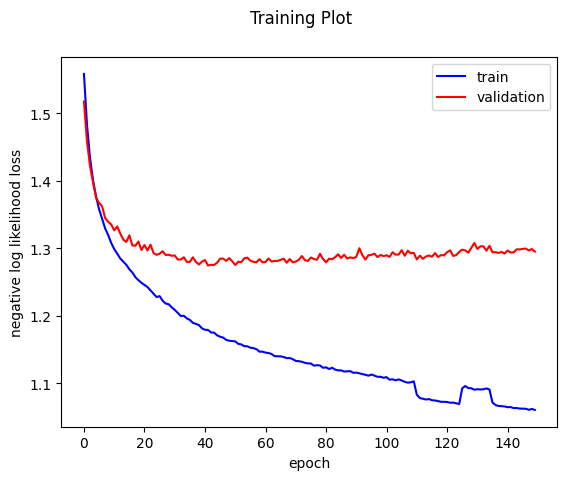

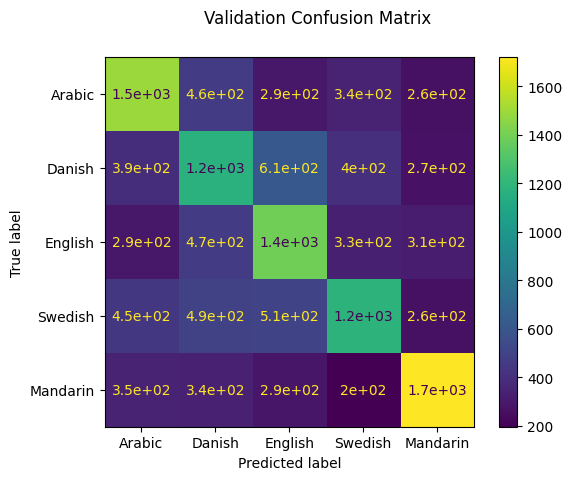

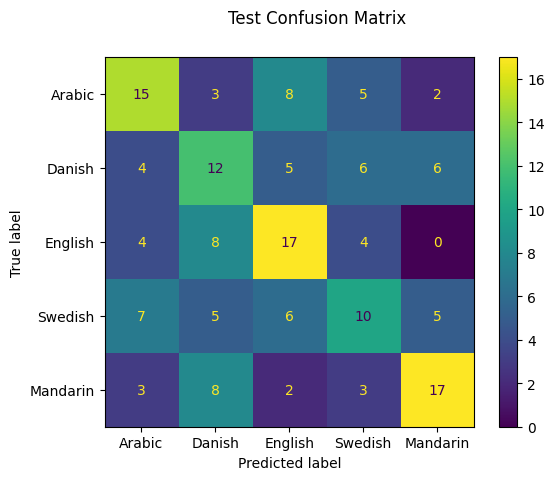

In [43]:
show_model(RESULTS.loc[["batch_size=64__learning_rate=0.0005__model=ShallowCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.pt"]],
           train=True, conf_valid=True, conf_test=True)

In [44]:
class ShallowCNNTDNN(nn.Module):
    def __init__(self):
        super(ShallowCNNTDNN, self).__init__()

        self.tdnn1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=39)
        self.flatten = nn.Flatten(-2, -1)
        self.output = nn.Linear(12, N_LANGUAGES)

    def forward(self, x):
        x = self.tdnn1(x)
        x = F.relu(x)
        x = torch.sum(x, dim=3)
        x = self.flatten(x)
        x = torch.clamp(x, min=-1, max=1)
        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        return x


#### Deep Architechture
The Deep CNNTDNN extends the shallow architecture by creating three convolutional layers instead of only one. Each convolutional layer uses max pooling layer and a relu activation function.

##### **Hyperparameters**
Two hyperparameters were changed for this model - several learning rates from 0.0001, 0.0005, 0.001, 0.005, and 0.01 were tested, as well as varying weight decay values from 0, 0.001, 0.01, and 0.1.

With no weight decay, the learning rates of 0.005 and 0.01 were found to be too high, as the model was unable to converge and, based on the confusion matrix and accuracy scores of around 20%, would just randomly pick one language to guess. Starting off with a learning rate of 0.0001, while effective, took more epochs to train. The best balance between training time, the negative log likelihood loss (error rate), and accuracy, seemed to be with a learning rate of 0.001.

Then, we tested various weight decay values. A higher weight decay lowered the difference between the training and validation error rates, but the overall error rates were higher, the model did not converge, and the results were more erratic from epoch to epoch. On the other hand, using a small weight decay value helped the model converge faster and with a lower validation loss. The best value for weight decay, across multiple learning rates, was found to be 0.001.

With this in mind, we used a learning rate scheduler to decrease the learning rate after several epochs. Without the learning rate scheduler, the best deep CNNTDNN models (with a learning rate of 0.001 or 0.0005 and weight decay of 0.001) had a training accuracy of 82% and a validation accuracy of 77%. With a learning rate scheduler and starting from a learning rate of 0.001 with a weight decay of 0.001, these accuracies could be increased to 85-86% and 79% respectively. This could be achieved either by stepping down the learning rate once (with a gamma of 0.5) when the error loss curve flattens out at around 60 epochs (MultiStepLR) or by continually stepping down every 20 epochs (StepLR). The advantage of multiple steps is that as the learning rate gets smaller and smaller, the error loss graph smoothens out.

In [45]:
RESULTS.loc[RESULTS.Model=="DeepCNNTDNN"]

,Model,Learning Rate,Weight Decay,Optimizer,LR_Scheduler,Dropout,Batch Size,Training Epochs,Train Loss,Validation Loss,Test Loss,Validation Accuracy,Test Accuracy,Validation Confusion Matrix,Test Confusion Matrix,training_plot
batch_size=64__learning_rate=0.01__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.pt,DeepCNNTDNN,0.01,0,adam,NaN,NaN,64,46,1.612,1.610,1.611,19.975,20.000,Figure(640x480),Figure(640x480),Figure(640x480)
batch_size=64__learning_rate=0.01__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.001.pt,DeepCNNTDNN,0.01,0.001,adam,NaN,NaN,64,15,1.612,1.611,1.611,19.975,20.000,Figure(640x480),Figure(640x480),Figure(640x480)
batch_size=64__learning_rate=0.01__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.01.pt,DeepCNNTDNN,0.01,0.01,adam,NaN,NaN,64,5,1.612,1.613,1.613,19.975,20.000,Figure(640x480),Figure(640x480),Figure(640x480)
batch_size=64__learning_rate=0.005__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.001.pt,DeepCNNTDNN,0.005,0.001,adam,NaN,NaN,64,10,1.612,1.613,1.612,19.519,20.000,Figure(640x480),Figure(640x480),Figure(640x480)
batch_size=64__learning_rate=0.005__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.pt,DeepCNNTDNN,0.005,0,adam,NaN,NaN,64,3,1.612,1.612,1.612,19.519,20.000,Figure(640x480),Figure(640x480),Figure(640x480)
batch_size=64__learning_rate=0.001__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.pt,DeepCNNTDNN,0.001,0,adam,NaN,NaN,64,100,0.657,0.782,0.939,71.022,60.606,Figure(640x480),Figure(640x480),Figure(640x480)
batch_size=64__learning_rate=0.0001__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.001.pt,DeepCNNTDNN,0.0001,0.001,adam,NaN,NaN,64,100,0.622,0.677,0.853,75.576,66.667,Figure(640x480),Figure(640x480),Figure(640x480)
batch_size=64__learning_rate=0.0005__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.pt,DeepCNNTDNN,0.0005,0,adam,NaN,NaN,64,100,0.507,0.738,1.036,73.895,64.242,Figure(640x480),Figure(640x480),Figure(640x480)
batch_size=64__learning_rate=0.0005__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.001.pt,DeepCNNTDNN,0.0005,0.001,adam,NaN,NaN,64,100,0.495,0.614,0.808,77.741,71.515,Figure(640x480),Figure(640x480),Figure(640x480)
batch_size=64__learning_rate=0.0001__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.01.pt,DeepCNNTDNN,0.0001,0.01,adam,NaN,NaN,64,100,0.916,0.942,1.062,66.013,59.394,Figure(640x480),Figure(640x480),Figure(640x480)


|                     | batch_size=64__learning_rate=0.001__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.001__MultiStep=60.pt   |
|:--------------------|:-----------------------------------------------------------------------------------------------------------------------------|
| Model               | DeepCNNTDNN                                                                                                                  |
| Learning Rate       | 0.001                                                                                                                        |
| Weight Decay        | 0.001                                                                                                                        |
| Optimizer           | adam                                                                                                                         |
| LR_Scheduler        | MultiStep=60                                                          

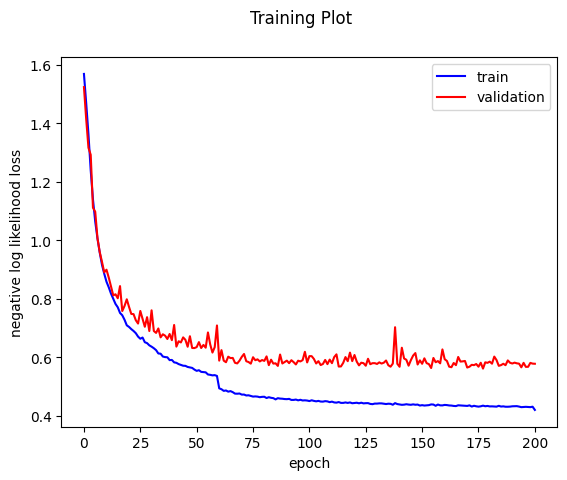

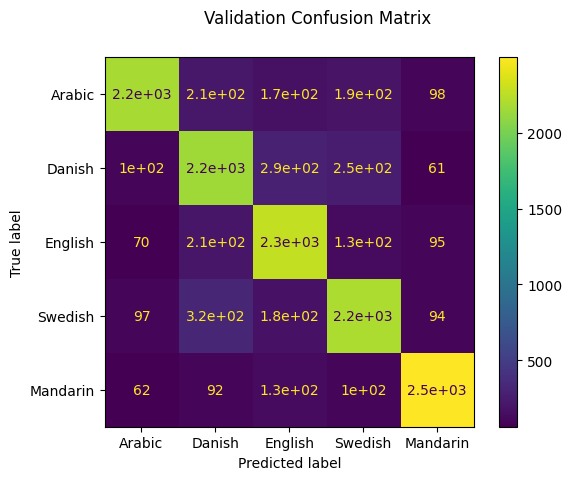

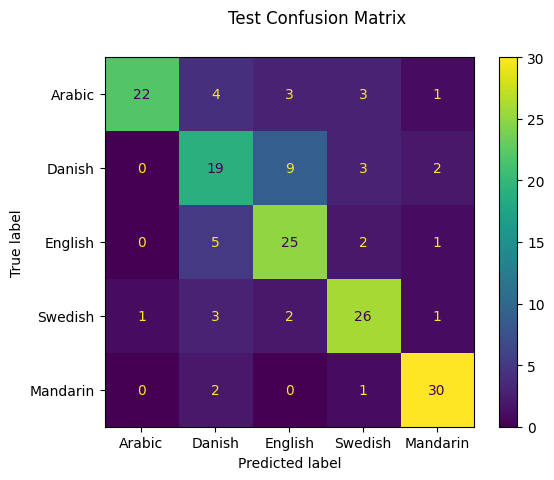

In [46]:
show_model(RESULTS.loc[["batch_size=64__learning_rate=0.001__model=DeepCNNTDNN__momentum=0.5__optim_param=adam__weight_decay=0.001__MultiStep=60.pt"]],
           train=True, conf_valid=True, conf_test=True)

In [47]:
class DeepCNNTDNN(nn.Module):
    def __init__(self):
        super(DeepCNNTDNN, self).__init__()

        self.tdnn1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=6)
        self.mp1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.tdnn2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=6)
        self.mp2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.tdnn3 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=6)
        self.flatten = nn.Flatten(-2, -1)
        self.output = nn.Linear(12, N_LANGUAGES)

    def forward(self, x):
        x = self.mp1(F.relu(self.tdnn1(x)))
        x = self.mp2(F.relu(self.tdnn2(x)))
        x = F.relu(self.tdnn3(x))
        x = torch.sum(x, dim=3)
        x = self.flatten(x)
        x = torch.clamp(x, min=-1, max=1)
        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        return x



## Bi-LSTM

### Models and/or Methods

*Model(s) and/or Method(s) are judiciously chosen and appropriately applied. If building on previous work, identify the source and clearly delineate which parts are your own work. (4 marks)*

To improve upon our Deep model we wanted to introduce new techniques. We therefore looked at the article “Language Identification Using Deep Convolutional Recurrent Neural Networks”, by Bartz, et.al. In this article, the authors train a CNN model on a self made dataset. They then add a BLSTM to the model as their recurrent network. As a result, their model showed significant improvement.

**Model Architecture:**

The idea behind the model is that the convolutional network works as a feature extractor while the BLSTM combines the extracted features over time. The feature extractor is the CNN with seven convolutional layers using the ReLU activation function. Five of the layers were followed by a max pool layer, and all seven used batch normalisation. Then the model performs stacking and slicing in order to make the output of the CNN compatible with the BLSTM. Finally the BLSTM consists of two LSTMs followed by a fully connected layer with the output units as the classifier. LogMax is applied as the final activation function.

Note: Due to an inconsistency in the research paper and their related Github Repository our model has seven convolutional layers compared to the papers five. However, as described in the paper the idea was to improve upon a pure CNN model by adding an RNN. In addition, they discuss a greater depth in the feature extractor as a positive correlation with their models performance. Therefore, we believe that this change only had positive influence on our models performance and did not change the conclusions we made on our experiments.

[Paper](https://arxiv.org/pdf/1708.04811.pdf)

|                     | batch_size=64__learning_rate=0.0001__model=CNNBiLSTM__momentum=0.5__optim_param=adam2__weight_decay=0.001.pt   |
|:--------------------|:---------------------------------------------------------------------------------------------------------------|
| Model               | CNNBiLSTM                                                                                                      |
| Learning Rate       | 0.0001                                                                                                         |
| Weight Decay        | 0.001                                                                                                          |
| Optimizer           | adam2                                                                                                          |
| LR_Scheduler        | nan                                                                                                            |
| Dropout             | nan              

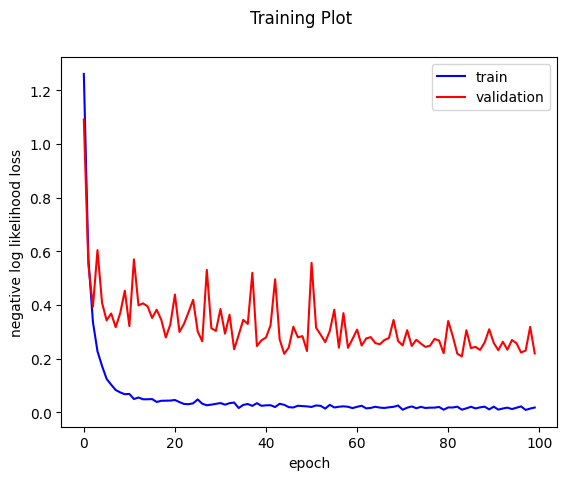

In [48]:
show_model(RESULTS.loc[["batch_size=64__learning_rate=0.0001__model=CNNBiLSTM__momentum=0.5__optim_param=adam2__weight_decay=0.001.pt"]],
           train=True, conf_valid=False, conf_test=False)

*Note: The negative log likelihood loss is the error rate of our model.*

**Hyperparameters**

Upon initial testing our model (the graph above), it was overfitting to the training data. After only five or six epochs its accuracy on the training data was 99%. The validation set also follows the performance of the training data up to around three epochs. However, as you can see on the graph, the error rate on the validation set remained high and very volatile. The initial learning rate was 0.0001 and it achieved an accuracy of 93.66% on the validation set.

What is interesting is that rerunning it for fifty seven only decreased the accuracy on the validation set to 93.20%. Thereby confirming that our cutoff at sixty epochs was appropriate. It was run for fifty seven epochs instead of sixty as the training environment cut out with three epochs left to go.

Next we wanted to see if we could improve the model by adjusting the learning rate. Below is the graph of the error rate for the model with a learning rate of 0.0001 that ran for fifty seven epochs. As you can see the validation error rate is very volatile. In addition, we wanted to see if we could improve the accuracy of the model. Therefore, we wanted first to try and increase the error rate.

|                     | batch_size=64__learning_rate=0.0001__model=CNNBiLSTM__momentum=0.5__optim_param=adam1__weight_decay=0.001.pt   |
|:--------------------|:---------------------------------------------------------------------------------------------------------------|
| Model               | CNNBiLSTM                                                                                                      |
| Learning Rate       | 0.0001                                                                                                         |
| Weight Decay        | 0.001                                                                                                          |
| Optimizer           | adam1                                                                                                          |
| LR_Scheduler        | nan                                                                                                            |
| Dropout             | nan              

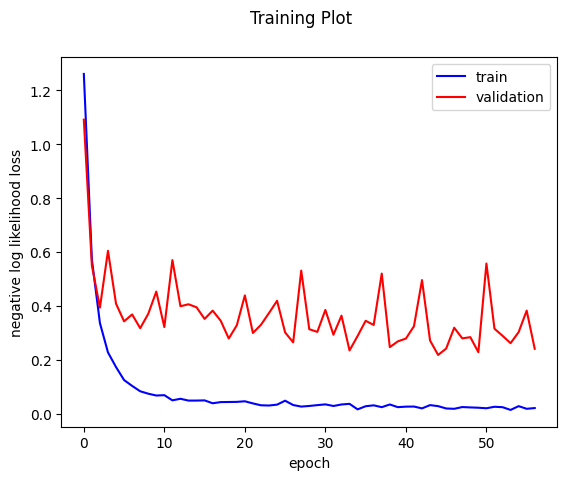

In [49]:
show_model(RESULTS.loc[["batch_size=64__learning_rate=0.0001__model=CNNBiLSTM__momentum=0.5__optim_param=adam1__weight_decay=0.001.pt"]],
           train=True, conf_valid=False, conf_test=False)

We than chose to increase the learning rate to 0.0005. It then achieved a lower accuracy of 88.3% on the validation set. As you can see from the graph below the error rate was still volatile and its performance on training and validation seemed more disconnected. Looking at the volatility in the error rate it indicates that the learning rate is too high. The changes in the error rate over short periods of time tells us that the model is making steps that are too large. In addition, we knew from previous testing on our deep model that a higher learning rate kept the model from converging. Therefore, we next tried to decrease the learning rate.

|                     | batch_size=64__learning_rate=5e-05__model=CNNBiLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001.pt   |
|:--------------------|:-------------------------------------------------------------------------------------------------------------|
| Model               | CNNBiLSTM                                                                                                    |
| Learning Rate       | 5e-05                                                                                                        |
| Weight Decay        | 0.001                                                                                                        |
| Optimizer           | adam                                                                                                         |
| LR_Scheduler        | nan                                                                                                          |
| Dropout             | nan                            

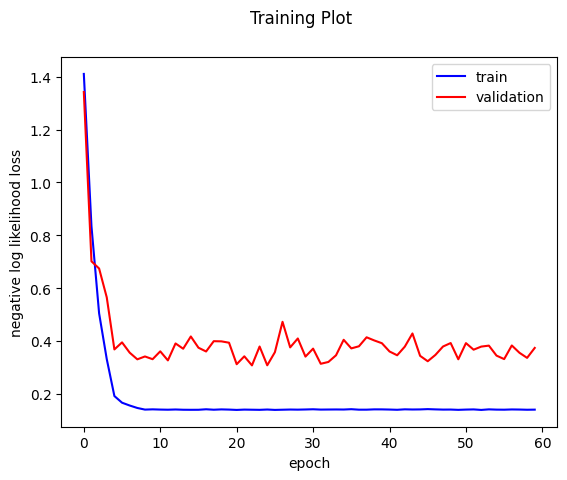

In [50]:
show_model(RESULTS.loc[["batch_size=64__learning_rate=5e-05__model=CNNBiLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001.pt"]],
           train=True, conf_valid=False, conf_test=False)

**Learning rate Schedular**

Due to the error rate’s volatility we decided to try a learning rate schedular. The basic idea is to decrease the learning rate as the model runs through epochs. Our hypothesis was that this would decrease the volatility in the validation error rate by decreasing the step size. We chose to use a multi step learning rate schedular that multiplies the learning rate by a factor of 0.1 every five epochs. We started with our optimal learning rate of 0.0001.
The graph below is the resulting validation and training error. Towards the end the internet connection dropped out and therefore reset the schedular. That meant the learning rate was back to 0.0001 and it therefore increased the error. In light of this please view the results discussed below up until fifty three epochs.

As you can see on the graph the validation error rate is a lot less volatile, even compared to the learning rate of 0.00005. At the same time, the training error rate fully converges. In addition, this model achieved a validation accuracy of 92.78%, slightly less than our previous optimal model with a learning rate of 0.0001. However, it seems to have a lower validation error than the optimal model and we therefore concluded that this was slightly better.

|                     | batch_size=64__learning_rate=0.0001__model=CNNBiLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001__StepLR_step=5_gamma=0.1.pt   |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------------|
| Model               | CNNBiLSTM                                                                                                                              |
| Learning Rate       | 0.0001                                                                                                                                 |
| Weight Decay        | 0.001                                                                                                                                  |
| Optimizer           | adam                                                                                                                                   |
| LR_Scheduler        | StepLR_ste

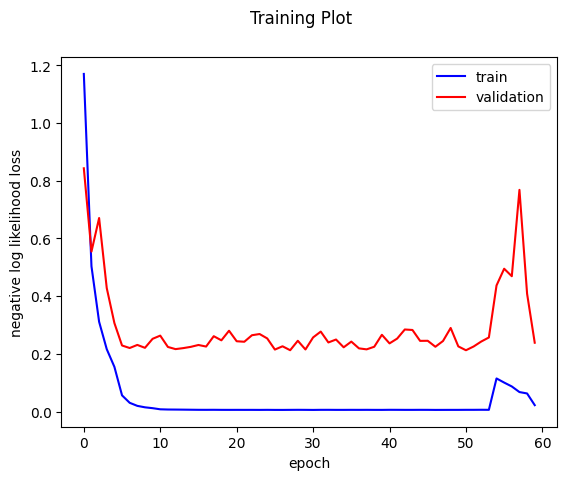

In [51]:
show_model(RESULTS.loc[["batch_size=64__learning_rate=0.0001__model=CNNBiLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001__StepLR_step=5_gamma=0.1.pt"]],
           train=True, conf_valid=False, conf_test=False)

**Dropout**

Since the model was still overfitting to the training data we wanted to try to use dropout. We ran the model above with a 20% dropout. The layer was placed in the CNN part of the architecture. It resulted in a validation accuracy of only 87.5%. This model only ran for forty six epochs, but showed higher volatility in the validation error compared to the model above.
We also ran the model without a learning rate schedular and a learning rate set to 0.0001 with a dropout layer set to 80%. The layer was placed after the BLSTM in the architecture. However, this as well decreased the validation accuracy to 90.21% and showed no improvement in the overfitting displayed by the error rate graph.

In [52]:

'''
    CNN-BiLSTM defined in Language Identification Using Deep Convolutional Recurrent Neural Networks
    by Christian Bartz, Tom Herold, Haojin Yang and Christoph Meinel
    https://arxiv.org/pdf/1708.04811.pdf
'''
class CNNBiLSTM(nn.Module):
    def __init__(self, dropout_value=0):
        super(CNNBiLSTM, self).__init__()
        # Papers recommended values:
        # weight_decay = 0.001 - Adjust in training block below
        # Stride = 3 for conv - had to use 1 to make it work and padding

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.mp1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.mp2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.mp3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(512)
        self.mp4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.batchnorm7 = nn.BatchNorm2d(512)
        self.mp5 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.Permute = lambda x: x.permute(0, 2, 1, 3) # Permute (bs, y, x, c) --> (bs, x, y, c)
        self.Reshape = lambda x: x.view(x.size(0), x.size(1), -1)  # Reshape (bs, x, y, c) --> (bs, x, y * c)
        self.Reshape2 = lambda x: x.view(x.size(0), -1) # Reshape (bs, x, c) --> (bs, x * yc)

        self.bidirectional_lstm = nn.LSTM(9216, 256, bidirectional=True, batch_first=True)
        self.output = nn.Linear(256 * 2, N_LANGUAGES)

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.mp1(x)

        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.mp2(x)

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)

        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        x = self.mp3(x)

        x = F.relu(self.conv5(x))
        x = self.batchnorm5(x)

        x = F.relu(self.conv6(x))
        x = self.batchnorm6(x)
        x = self.mp4(x)

        x = F.relu(self.conv7(x))
        x = self.batchnorm7(x)
        x = self.mp5(x)

        x = self.Permute(x)
        x = self.Reshape(x)
        x = self.Reshape2(x)

        x, _ = self.bidirectional_lstm(x)
        x = self.dropout(x)
        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        return x

##Results##
**Final Recommendation**

Taking our learnings from the different learning rates, learning rate schedular, and use of dropout layers, we concluded that our optimal model for this project was using a learning rate of 0.0001 with a schedular that multiplied the learning rate by 0.1 for every five epochs. This model was able to achieve a validation accuracy of 92.78% and test accuracy of 88.48% with potential for even better results. It was also able to achieve a stable validation error while converging on the training data.

**Evaluation of confusion matrix**

In addition to the error rates and accuracy, we also chose to use a confusion matrix as an evaluation metric. We chose to use a confusion matrix as it allows us to see what languages the model has a struggle predicting. Below is the confusion matrix for the validation data on our final model. It shows us that it often confuses Danish for Swedish and English for Danish. This makes sense as Danish and Swedish both belong to north germanic languages while English and Danish are both germanic. At the same time, for example mandarin has very few misclassified instances as it is very different from the other languages.

|                     | batch_size=64__learning_rate=0.0001__model=CNNBiLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001__StepLR_step=5_gamma=0.1.pt   |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------------|
| Model               | CNNBiLSTM                                                                                                                              |
| Learning Rate       | 0.0001                                                                                                                                 |
| Weight Decay        | 0.001                                                                                                                                  |
| Optimizer           | adam                                                                                                                                   |
| LR_Scheduler        | StepLR_ste

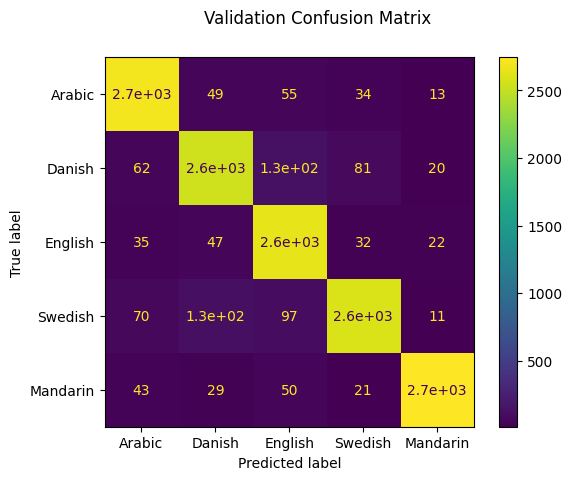

In [53]:
show_model(RESULTS.loc[["batch_size=64__learning_rate=0.0001__model=CNNBiLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001__StepLR_step=5_gamma=0.1.pt"]],
           train=False, conf_valid=True, conf_test=False)

**Comparison to the article model**

In the article the same CRNN model as ours, with different learning rates, was able to achieve a 98% accuracy. That is considerably higher than our result of 92%. However, they achieved that error rate on a different dataset that used recordings of debates, and press conferences in the EU parliament. One can speculate that these recordings contain less noise which resulted in a higher accuracy for their model compared to ours.

**Limitations**

A major limitation for the model was its training time. The model has over twenty six million trainable parameters and it took just over four hours to train at sixty epochs. Therefore, hyperparameter tuning takes a long time and was limited due to time constraints of the project. It is also very resource intensive. All the training had to be done on the Google Colab T4 High Ram GPU’s as it was not possible to perform the training on a standard laptop.

**Possible Future Work:**

- Re-run with the learning rate schedular to confirm improvement in accuracy.
- Dropout layers with different dropout rates and placed at other places in the model to decrease the overfitting to the training data.
- Adjust the size of the model. In the article the model is based on they tried deeper pre-trained CNN’s for their CRNN models which showed significant


## CNN-LSTM

The CNN-LSTM seen below was not derived from an existing paper but was developed for experimentation by our team. This was to find a balance between the accuracy of the CNN-BiLSTM and the speed of the Deep-CNNTDNN in an attempt to create a scalable model that took a reasonable training time and could achieve satisfactory accuracy.

The architecture for this model was chosen to be at a rough midpoint of the Deep-CNNTDNN and the CNN-BiLSTM. Hence, this has 4 convolutional, batchnorm and maxpooling layers (1 more than the Deep-CNNTDNN and 3 less than the CNN-BiLSTM) followed by the stacking, slicing, LSTM and fully connected layers. The CNN layers using ReLU activation work as feature extractors on the spectrograms while the LSTM combines the features.

##### **Hyperparameters**

Testing was conducted on two hyperparameters, the learning rate and weight decay. The learning rates tested were 0.00001, 0.00005, 0.0001, 0.005, and 0.001. The weight decays tested were 0.0001, 0.0005, 0.001, 0.005 and 0.1.

The learning rates were run over 100 epochs in an attempt to identify a cutoff point where the loss converged. This condition was not satisfied for the tests conducted. Large learning rates were found to result in rapid overfitting whilst small learning rates show signs of converging error over several hundred epochs. The best learning rate was identified at 0.0001.

Similarly, a weight decay of 0.01 was found to be the best. Higher weight decays were observed to lower the difference between the training and validation error rates, however at the cost of the volatility of the error rate.

A list of all the graphs and confusion matrices attained for the CNN-LSTM can be found below. Given more time, the implementation of a scheduler with varying learning rates may have helped improve the volatility by escaping the local minima. Closer analysis revealed the model struggled to distinguish between Danish and Swedish however shows proof of concept as it reduced the training time by 50% to 2hrs and the file size by 62% to 38MB.


|                     | batch_size=64__learning_rate=0.0001__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001.pt   |
|:--------------------|:------------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                     |
| Learning Rate       | 0.0001                                                                                                      |
| Weight Decay        | 0.001                                                                                                       |
| Optimizer           | adam                                                                                                        |
| LR_Scheduler        | nan                                                                                                         |
| Dropout             | nan                                   

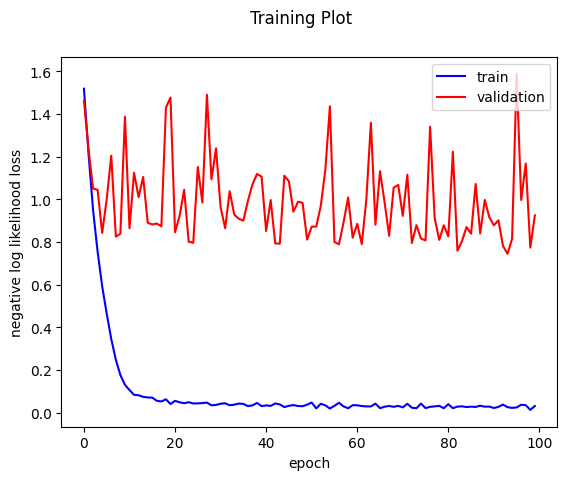

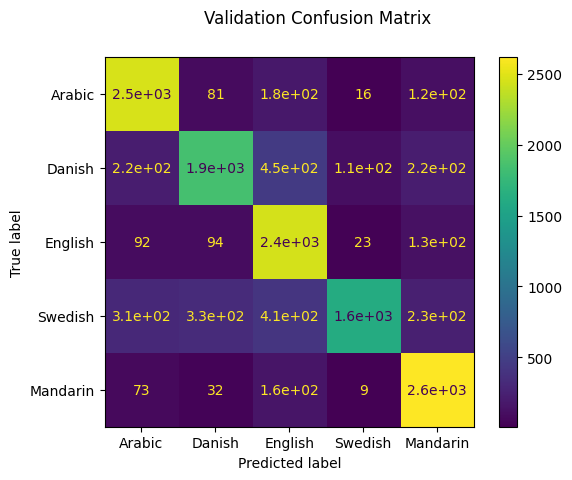

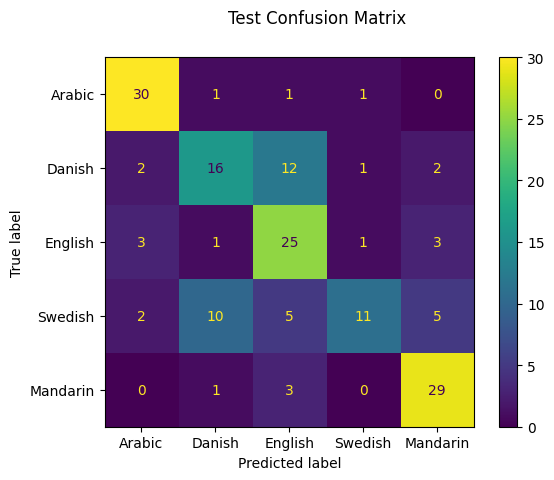

|                     | batch_size=64__learning_rate=0.001__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001.pt   |
|:--------------------|:-----------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                    |
| Learning Rate       | 0.001                                                                                                      |
| Weight Decay        | 0.001                                                                                                      |
| Optimizer           | adam                                                                                                       |
| LR_Scheduler        | nan                                                                                                        |
| Dropout             | nan                                          

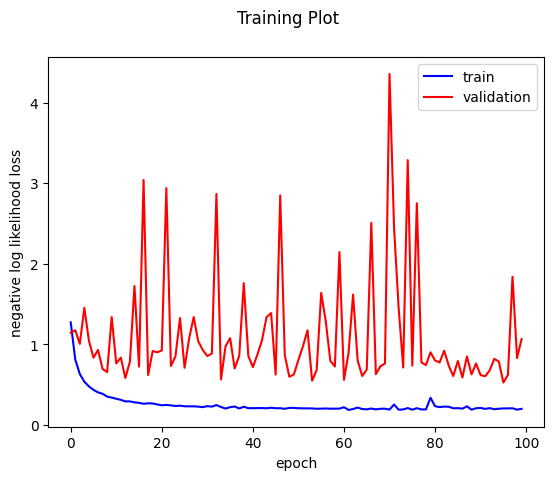

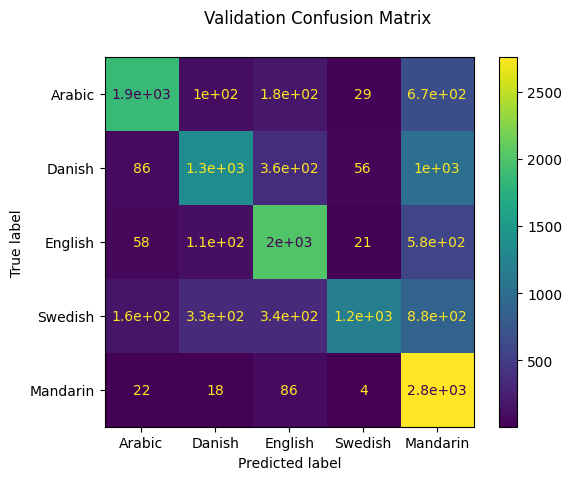

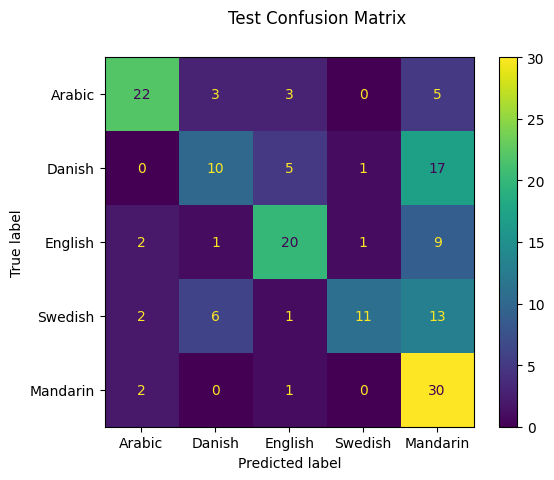

|                     | batch_size=64__learning_rate=1e-05__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001.pt   |
|:--------------------|:-----------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                    |
| Learning Rate       | 1e-05                                                                                                      |
| Weight Decay        | 0.001                                                                                                      |
| Optimizer           | adam                                                                                                       |
| LR_Scheduler        | nan                                                                                                        |
| Dropout             | nan                                          

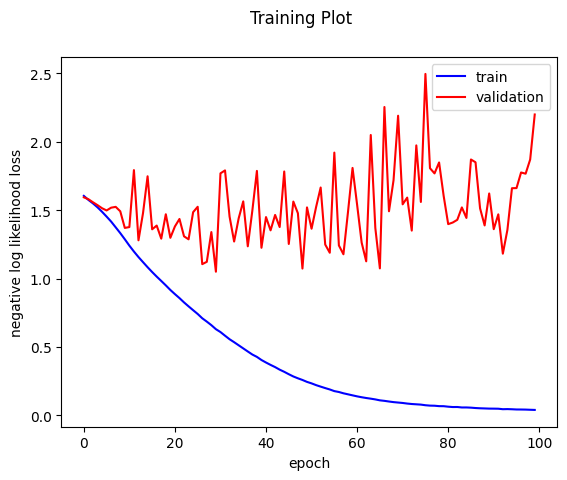

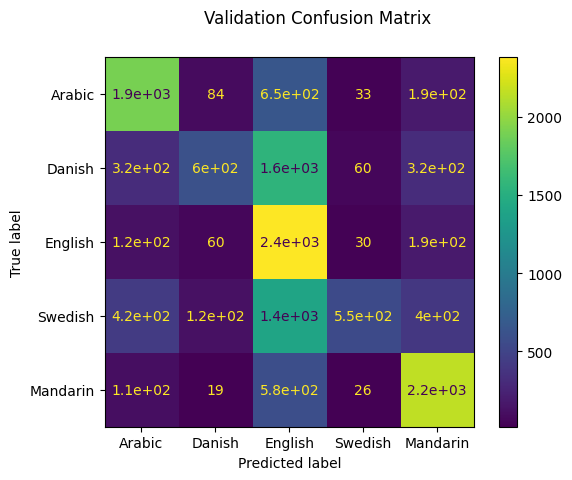

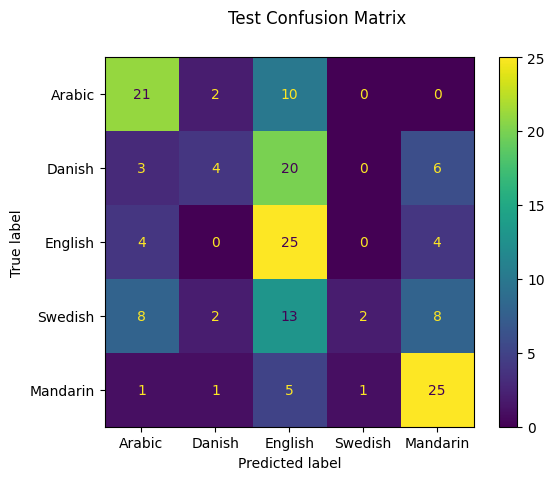

|                     | batch_size=64__learning_rate=5e-05__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001.pt   |
|:--------------------|:-----------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                    |
| Learning Rate       | 5e-05                                                                                                      |
| Weight Decay        | 0.001                                                                                                      |
| Optimizer           | adam                                                                                                       |
| LR_Scheduler        | nan                                                                                                        |
| Dropout             | nan                                          

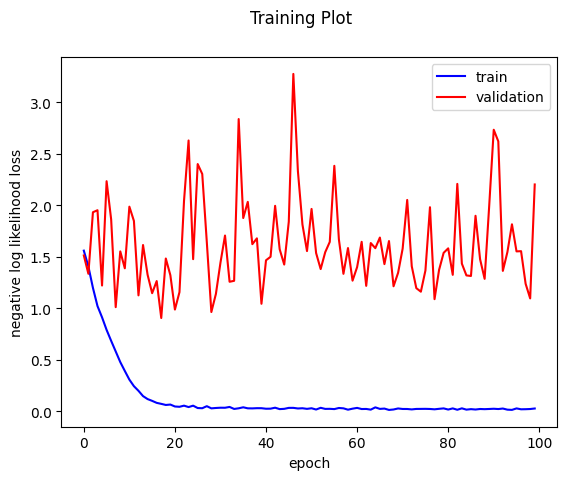

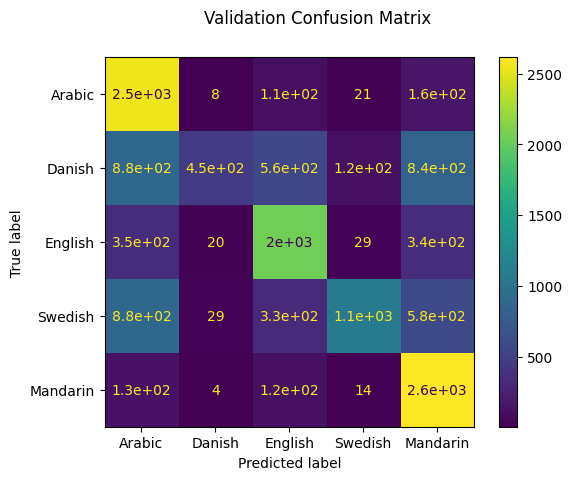

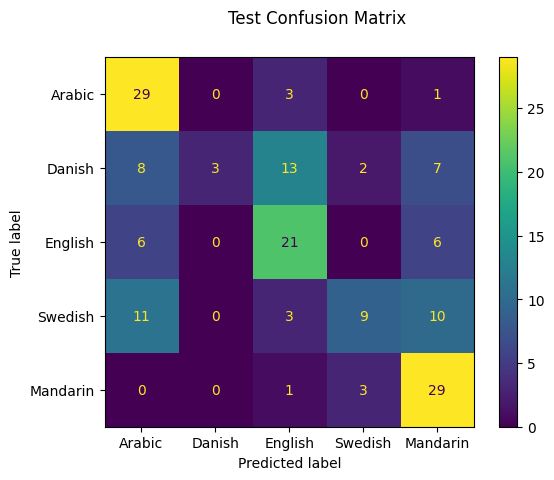

|                     | batch_size=64__learning_rate=0.005__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001.pt   |
|:--------------------|:-----------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                    |
| Learning Rate       | 0.005                                                                                                      |
| Weight Decay        | 0.001                                                                                                      |
| Optimizer           | adam                                                                                                       |
| LR_Scheduler        | nan                                                                                                        |
| Dropout             | nan                                          

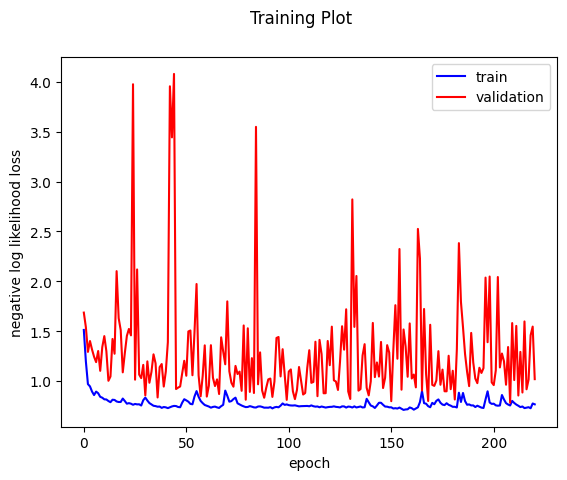

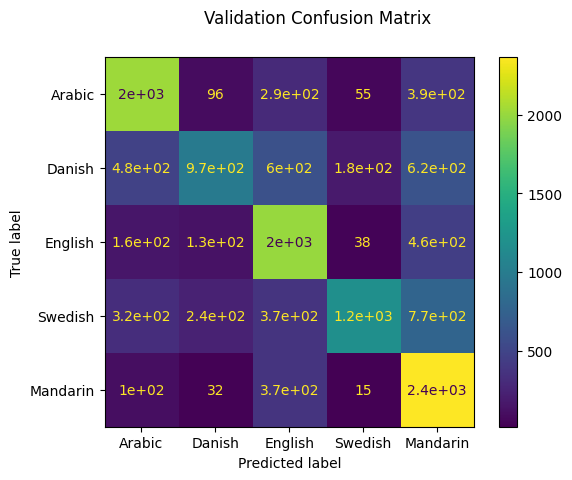

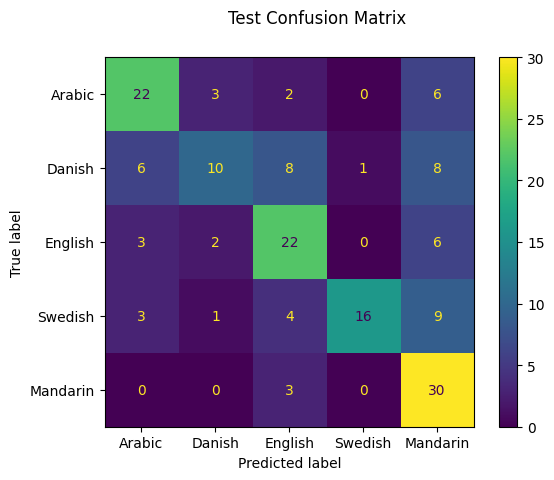

|                     | batch_size=64__learning_rate=0.0001__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.01.pt   |
|:--------------------|:-----------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                    |
| Learning Rate       | 0.0001                                                                                                     |
| Weight Decay        | 0.01                                                                                                       |
| Optimizer           | adam                                                                                                       |
| LR_Scheduler        | nan                                                                                                        |
| Dropout             | nan                                          

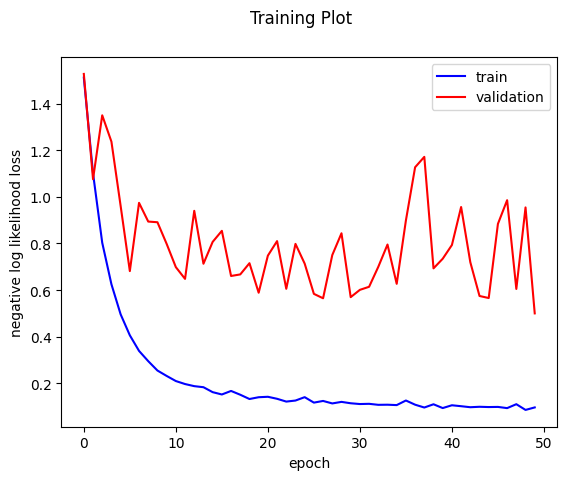

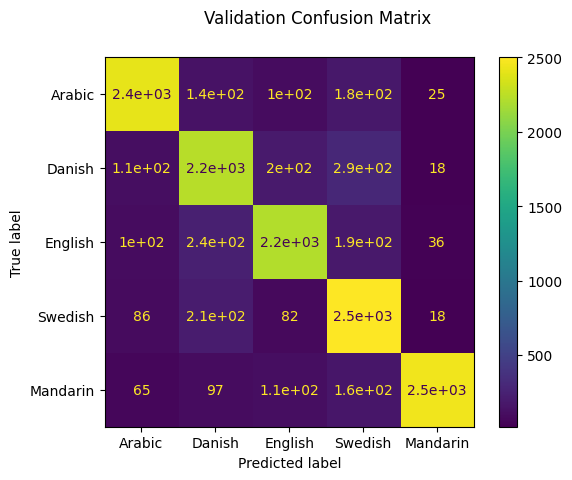

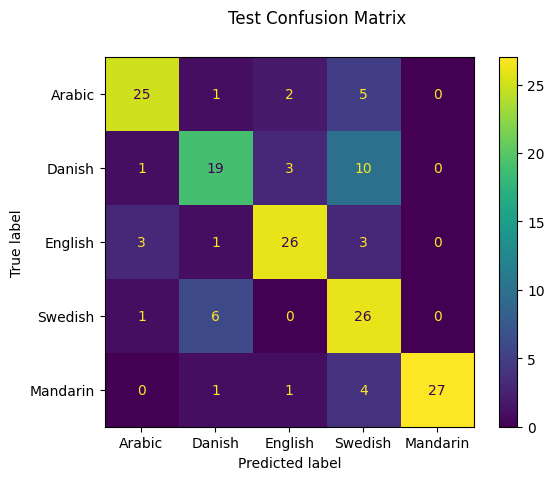

|                     | batch_size=64__learning_rate=0.0001__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.0005.pt   |
|:--------------------|:-------------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                      |
| Learning Rate       | 0.0001                                                                                                       |
| Weight Decay        | 0.0005                                                                                                       |
| Optimizer           | adam                                                                                                         |
| LR_Scheduler        | nan                                                                                                          |
| Dropout             | nan                            

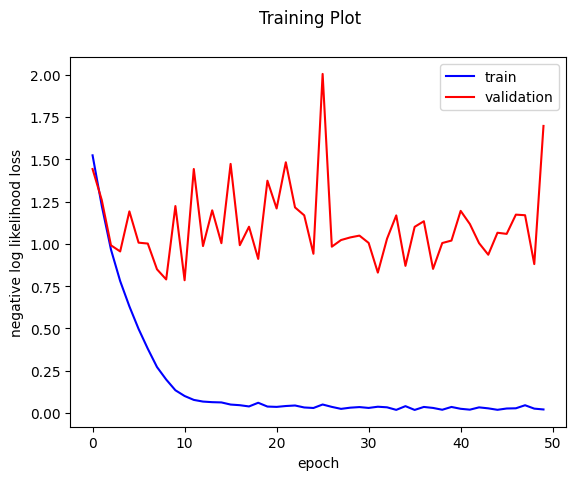

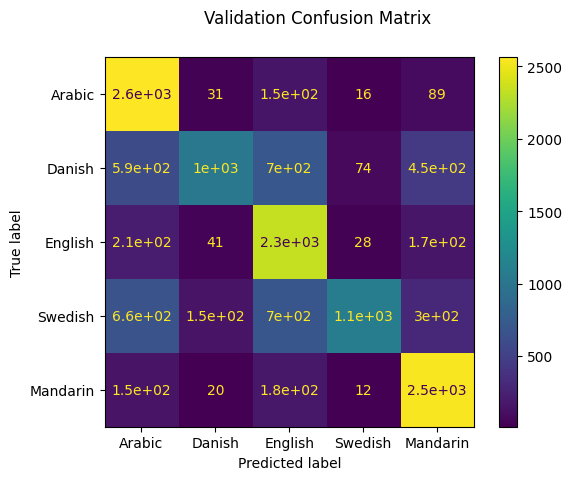

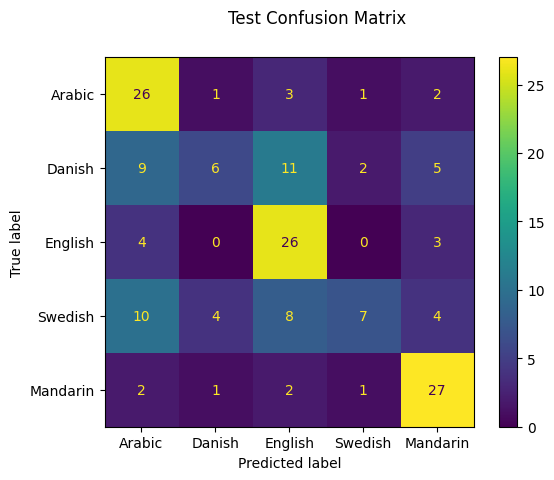

|                     | batch_size=64__learning_rate=0.0001__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001__StepLR5.pt   |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                              |
| Learning Rate       | 0.0001                                                                                                               |
| Weight Decay        | 0.001                                                                                                                |
| Optimizer           | adam                                                                                                                 |
| LR_Scheduler        | StepLR5                                                                                                              |

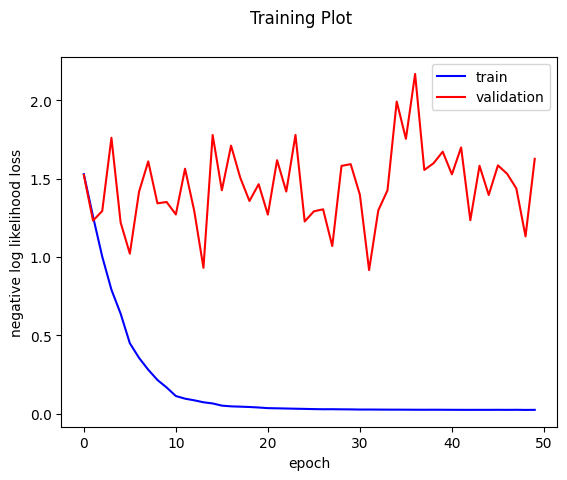

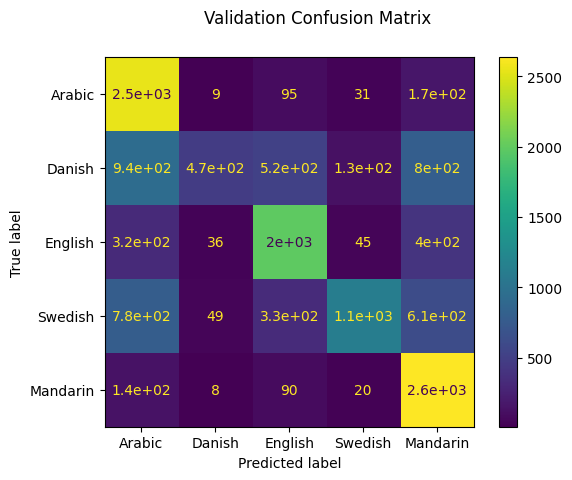

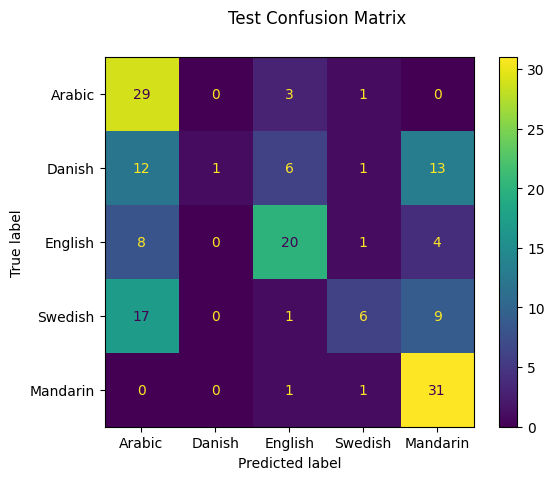

|                     | batch_size=64__learning_rate=0.0001__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.001__StepLR10.pt   |
|:--------------------|:----------------------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                               |
| Learning Rate       | 0.0001                                                                                                                |
| Weight Decay        | 0.001                                                                                                                 |
| Optimizer           | adam                                                                                                                  |
| LR_Scheduler        | StepLR10                                                                                                        

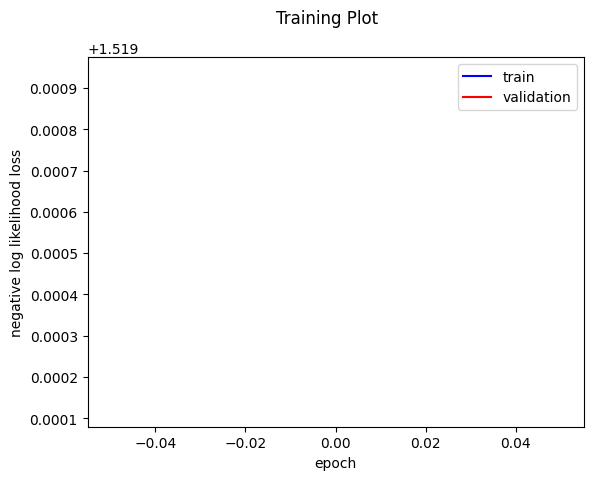

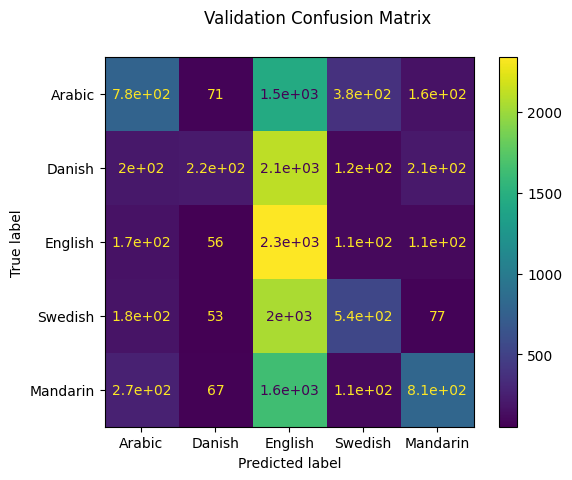

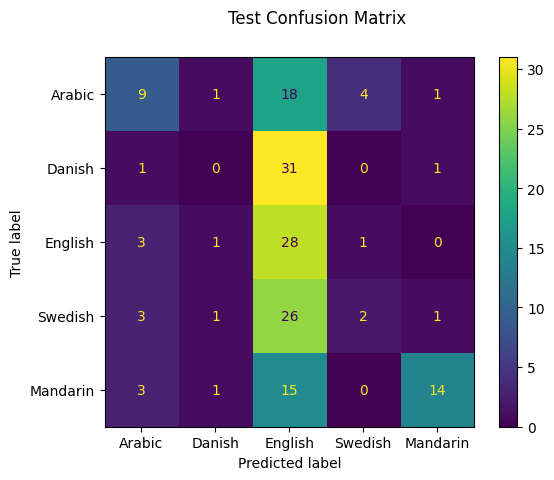

|                     | batch_size=64__learning_rate=0.0001__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.0001.pt   |
|:--------------------|:-------------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                      |
| Learning Rate       | 0.0001                                                                                                       |
| Weight Decay        | 0.0001                                                                                                       |
| Optimizer           | adam                                                                                                         |
| LR_Scheduler        | nan                                                                                                          |
| Dropout             | nan                            

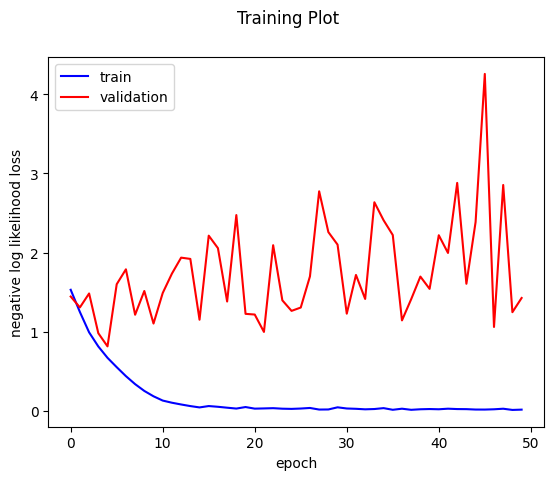

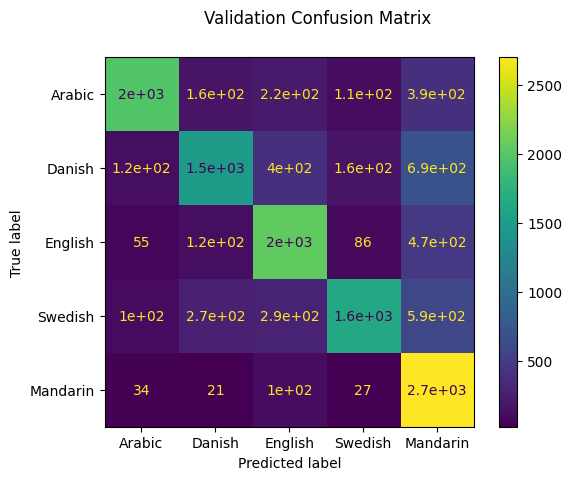

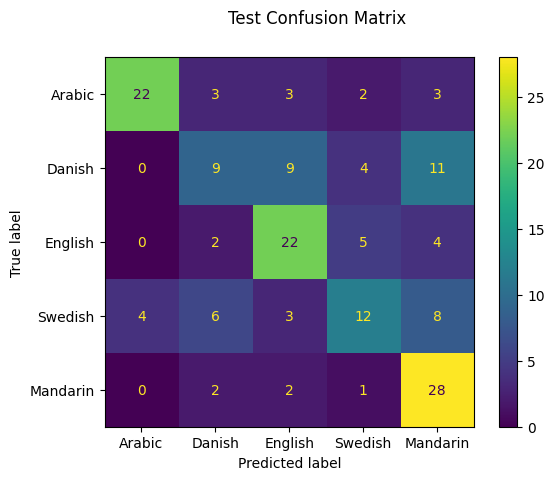

|                     | batch_size=64__learning_rate=0.0001__model=CNNLSTM__momentum=0.5__optim_param=adam__weight_decay=0.005.pt   |
|:--------------------|:------------------------------------------------------------------------------------------------------------|
| Model               | CNNLSTM                                                                                                     |
| Learning Rate       | 0.0001                                                                                                      |
| Weight Decay        | 0.005                                                                                                       |
| Optimizer           | adam                                                                                                        |
| LR_Scheduler        | nan                                                                                                         |
| Dropout             | nan                                   

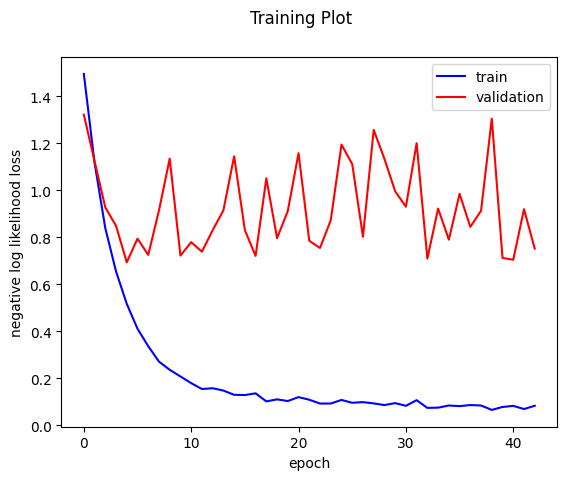

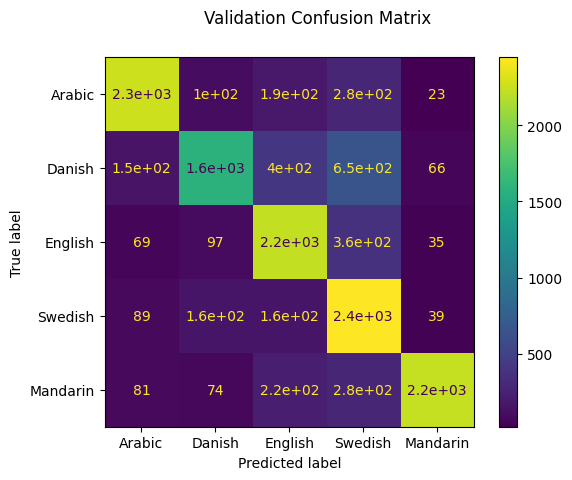

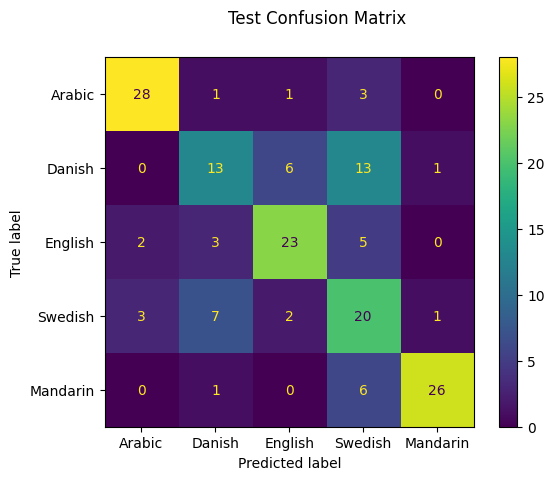

In [54]:
show_model(RESULTS.loc[RESULTS.Model=="CNNLSTM"],train=True, conf_valid=True, conf_test=True)

In [55]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=1, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.mp1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.mp2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=1, padding=0)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.mp3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=1, padding=0)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.mp4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.Permute = lambda x: x.permute(0, 2, 1, 3) # Permute (bs, y, x, c) --> (bs, x, y, c)
        self.Reshape = lambda x: x.view(x.size(0), x.size(1), -1)  # Reshape (bs, x, y, c) --> (bs, x, y * c)
        self.Reshape2 = lambda x: x.view(x.size(0), -1) # Reshape (bs, x, c) --> (bs, x * yc)

        self.lstm = nn.LSTM(9216, 256, bidirectional=False, batch_first=True)
        self.output = nn.Linear(256, N_LANGUAGES)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.mp1(x)

        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.mp2(x)

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.mp3(x)

        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        x = self.mp4(x)

        x = self.Permute(x)
        x = self.Reshape(x)
        x = self.Reshape2(x)

        x, _ = self.lstm(x)
        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        return x


In [56]:
RESULTS.reset_index()[show_cols]

,Model,Learning Rate,Weight Decay,Optimizer,LR_Scheduler,Dropout,Batch Size,Training Epochs,Train Loss,Validation Loss,Test Loss,Validation Accuracy,Test Accuracy
0,CNNBiLSTM,0.0001,0.001,adam1,NaN,NaN,64,57,0.021,0.241,0.386,93.204,89.697
1,CNNBiLSTM,0.0001,0.001,adam2,NaN,NaN,64,100,0.018,0.219,0.363,93.666,90.303
2,CNNBiLSTM,0.0005,0.001,adam1,NaN,NaN,64,60,0.065,0.385,0.561,88.279,81.818
3,CNNBiLSTM,0.0001,0.001,adam3,NaN,NaN,64,100,0.018,0.219,0.363,93.666,90.303
4,CNNBiLSTM,0.0001,0.001,adam1,StepLR_step=5_gamma=0.1,NaN,64,60,0.022,0.238,0.454,92.777,88.485
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,ShallowCNNTDNN,0.005,0.001,adam,NaN,NaN,64,100,1.479,1.476,1.499,34.919,36.364
60,CNNBiLSTM,0.0001,0.001,adam,StepLR_step=5_gamma=0.1,NaN,64,60,0.022,0.238,0.454,92.777,88.485
61,ShallowCNNTDNN,0.01,0.001,adam,NaN,NaN,64,1,1.574,1.608,1.629,22.336,27.879
62,CNNBiLSTM,0.0001,0.001,adam,StepLR_step=5_gamma=0.1,0.200,64,46,0.045,0.417,0.729,87.529,78.788


We created a short demo showing the performance and limitations of our best BiLSTM and DeepCNNTDNN models. [Video link](https://www.youtube.com/watch?v=_cRvgtlNcBQ)

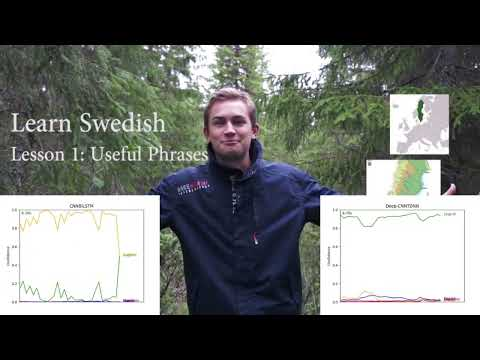

In [57]:
IPython.display.YouTubeVideo("_cRvgtlNcBQ")

## Discussion

Based on our demo, our model (both the Deep CNNTDNN and the CNN-BiLSTM) is able to distinguish the five different languages in a real-world scenario, though it makes some mistakes when there is background noise or when people are speaking with accents.

To improve our model, more parameters aside from learning rate and weight decay could be tested, as well as different architectures. An increased set of samples for each language class would also help the model better distinguish edge cases such as accents. More preprocessing of the audio samples, such as voice activity detection and noise removal can improve learning as well, allowing the model to make good predictions even when there is background noise or music. Finally, our models were only trained on five languages, so increasing the number of languages that the model is trained on would increase its usability for real-world applications.


### Miscellaneous
The following Trainer class was used to perform training, testing, and

In [58]:
class Trainer():
    def __init__(self, model : str, optim_param : str, learning_rate : float, momentum : float, train_dataset, test_dataset, dev_dataset, batch_size : int, weight_decay : float, dropout : float= None, file_name=None, overwrite=False):
        self.model = model
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.overwrite = overwrite
        self.optim_param = optim_param
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.dropout = dropout

        self.train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, generator=rand_generator, batch_size=self.batch_size)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size)
        self.dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=self.batch_size)

        if model == 'DeepCNNTDNN':
            self.net = DeepCNNTDNN().to(DEVICE)
        elif model == 'ShallowCNNTDNN':
            self.net = ShallowCNNTDNN().to(DEVICE)
        elif model == 'CNNLSTM':
            self.net = CNNLSTM().to(DEVICE)
        elif model == 'CNNBiLSTM':
            d = dropout if dropout else 0
            self.net = CNNBiLSTM(d).to(DEVICE)
        else: # change this if other models are defined
            self.net = DeepCNNTDNN().to(DEVICE)

        if self.optim_param == 'adam':
            self.optimizer = optim.Adam(self.net.parameters(),
                                lr = learning_rate,
                                weight_decay = self.weight_decay)
        else:
            self.optimizer = optim.SGD(self.net.parameters(),
                                lr = learning_rate,
                                momentum = momentum,
                                weight_decay = self.weight_decay)

        if file_name:
            self.file_PATH = file_name
        else:
            self.file_PATH = os.path.join(model_PATH, "".join([f"{i[0]}={i[1]}__"
                            if (type(i[1]) in [str, int, float])
                            and not i[1] == "__main__" else ""
                            for i in sorted(inspect.getmembers(self))])[:-2]+".pt")

        self.loss = {"train":[], "test":[], "conf_matrix":[]}

        self.current_epoch = 0


        if os.path.isfile(self.file_PATH) and not self.overwrite:
            loaded = torch.load(self.file_PATH, map_location=DEVICE)
            self.loss = loaded["loss"]
            self.net.load_state_dict(loaded["net"])
            self.current_epoch = len(self.loss["test"])
            print(f"Loaded from epoch {self.current_epoch} from file: {self.file_PATH}")

        # StepLR changes the LR by set_size (for e.g for 5, LR changes every 5 steps)
        # MultiStep if you wants to specify different stages in epochs

        # self.schedular = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.5, verbose=True)
        # self.schedular = lr_scheduler.MultiStepLR(self.optimizer, milestones=[], gamma=0.5, verbose=True)

    def train(self, epoch):
        train_loss = 0
        correct = 0
        self.net.train()
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            self.optimizer.zero_grad()
            output = self.net(data)

            make_dot(output, params=dict(list(self.net.named_parameters()))).render("test_rnn_torchviz", format="png")
            loss = F.nll_loss(output, target)
            loss.backward()
            self.optimizer.step()

            train_loss += F.nll_loss(output, target, reduction='sum').item()
            # determine index with maximal log-probability
            pred = output.argmax(dim=1, keepdim=False)
            correct += pred.eq(target.view_as(pred)).sum().item()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(self.train_loader.dataset),
                    100. * batch_idx / len(self.train_loader), loss.item()))

        train_loss /= len(self.train_loader.dataset)
        # self.schedular.step()

        print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n==================================\n'.format(
            train_loss, correct, len(self.train_loader.dataset),
            100. * correct / len(self.train_loader.dataset)))
        return train_loss

    def test(self, dev=False):
        loader = self.dev_loader if dev else self.test_loader

        self.net.eval()
        test_loss = 0
        correct = 0
        conf_matrix = np.zeros((N_LANGUAGES,) * 2) # initialize confusion matrix
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = self.net(data)
                # print(target, output)

                # sum up batch loss
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                # determine index with maximal log-probability
                pred = output.argmax(dim=1, keepdim=False)
                correct += pred.eq(target.view_as(pred)).sum().item()
                # update confusion matrix
                conf_matrix = conf_matrix + metrics.confusion_matrix(
                            target.cpu(),
                            pred.cpu(),
                            labels=np.arange(N_LANGUAGES))
            # print confusion matrix
            np.set_printoptions(precision=4, suppress=True)
            test_loss /= len(loader.dataset)
            if not dev:
                print("\nConfusion Matrix:")
                print([(i, value) for i, value in enumerate(loader.dataset.classes)])
                print(conf_matrix)

                print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n==================================\n'.format(
                    test_loss, correct, len(loader.dataset),
                    100. * correct / len(loader.dataset)))

        return test_loss, conf_matrix

    def run(self, num_epochs):
        for epoch in range(self.current_epoch + 1, num_epochs + 1):
            self.loss["train"].append(self.train(epoch))
            test_loss, conf_matrix = self.test()
            self.loss["test"].append(test_loss)
            self.loss["conf_matrix"].append(conf_matrix)

            torch.save({"loss": self.loss, "net":self.net.state_dict()}, self.file_PATH)
            print(f"Save Epoch {epoch} to:  {self.file_PATH}")
            self.current_epoch += 1
